In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import os
import pandas as pd
from typing import Tuple
from termcolor import colored
from pathlib import Path

from scipy.interpolate import interp1d
from scipy.integrate import trapz, quad

<div class="alert alert-info" align="center"><b>STOCKAGE DES INFORMATIONS</b></div>

In [42]:
docs_path = Path.cwd().parent / "Docs"
img_path = docs_path / "img"
resultats_path = docs_path / "resultats"

# Création des dossiers si nécessaire
for path in [docs_path, img_path, resultats_path]:
    if not path.exists():
        path.mkdir(parents=True)
        print(f"Le dossier {colored(path.name, 'green')} a été créé.")
    else:
        print(f"Le dossier {colored(path.name, 'yellow')} existe déjà.")

Le dossier Docs existe déjà.
Le dossier img existe déjà.
Le dossier resultats existe déjà.


<div class="alert alert-info" align="center"><b>SYNTHESE CONTRAINTE VARIABLES DU MISSILE - MOTEUR : STATORÉACTEUR</b></div>

In [43]:
## DONNÉES
t_acc = 4.85655564067031
t_cruise = 143.82010925319975
t_mission = t_acc + t_cruise

    # thermophysique
gamma = 1.4
P_amb = 101325
T_amb = 288
r_air = 8.314 / (28.966*1e-3)
g0 = 9.80665
Mach_cruise = 2.0
Mach_acc = 0.6
V_son = np.sqrt(gamma * r_air * T_amb)
Delta_Vr = (Mach_cruise - Mach_acc) * V_son

    # Impulsion spécifique
Isp_acc = 240

    # masse volumique
rho_a = 1800
rho_c = 1000
rho_payload = 3000
rho_equipement = 1500

    # masses
m_ogive = 25
m_equipement = 55
m_payload = 200
m_engine_h = 10
m_nozzle = 12
m_tails = 16

    # coefficient
c_a = 0.7
i_a = 0.28
c_c = 0.9
i_c = 0.22

    # diamètre vecteur
dt = 0.001
d_missile = np.arange(0.2, 0.6 + dt, dt)
shape = d_missile.shape[0]


<div class="alert alert-success" align="center"><b>PARAMÈTRES DE LA SIMULATION</b></div>

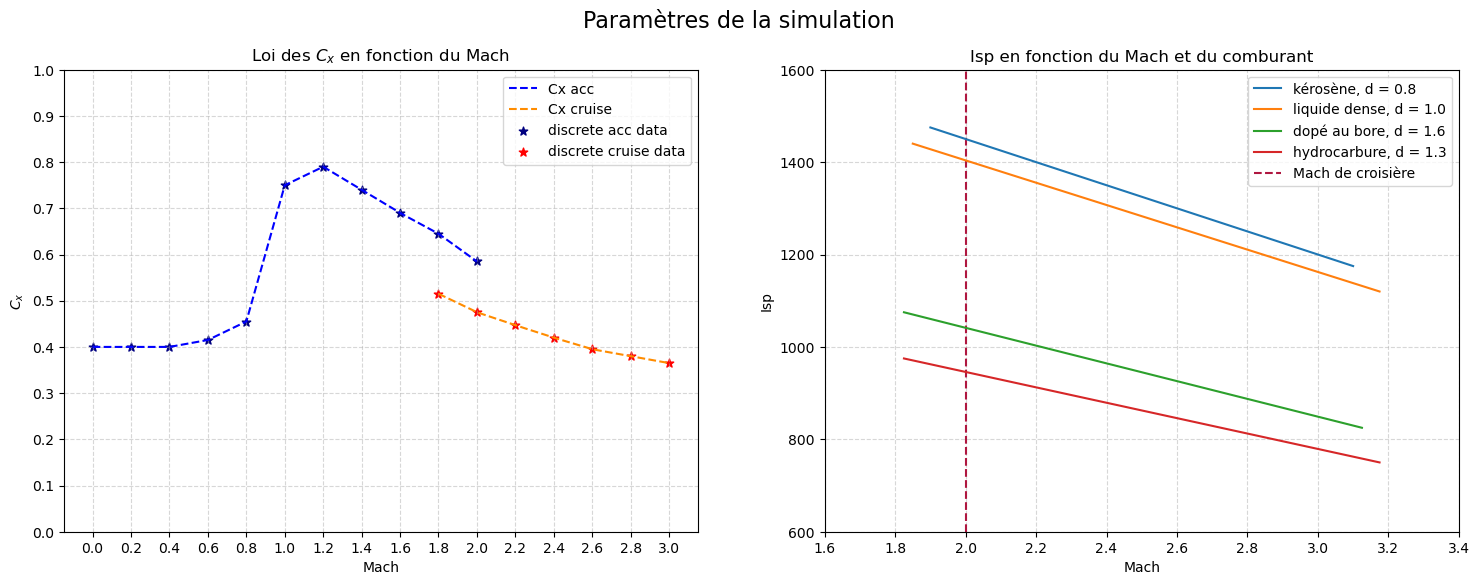

In [44]:
from dimensioning_functions.generate_Cx_Isp import generate_Cx_Isp

keys_dict_main, cruise_data_dict, Cx_acc_arr, Mach_acc_arr, isp_value, Cd_c, densite_value = generate_Cx_Isp(Mach_cruise=Mach_cruise, shape=d_missile.shape[0], 
                                                                                                             img_path=img_path)

time = {
    't_acc': t_acc,
    't_cruise': t_cruise,
}

data_mission = {
    'gamma': gamma,
    'P_amb': P_amb,
    'Mach_cruise': Mach_cruise,
    'g0': g0,
    'Cd_c': Cd_c,
    'Delta_Vr': Delta_Vr,
    'Isp_acc': Isp_acc,
    'mass': {
        'm_ogive': m_ogive,
        'm_equipement': m_equipement,
        'm_tails': m_tails,
        'm_payload': m_payload,
        'm_engine_h': m_engine_h,
        'm_nozzle': m_nozzle
    },
    'rho': {
        'rho_payload': rho_payload,
        'rho_equipement': rho_equipement,
        'rho_c': rho_c,
        'rho_a': rho_a
    }
}

c = {
    'c_a': c_a,
    'c_c': c_c
}

i = {
    'i_a': i_a,
    'i_c': i_c
}

graph_component = {
    'Mach_acc_arr': Mach_acc_arr,
    'Cx_acc_arr': Cx_acc_arr
}

iterate = {
    'keys_dict_main': keys_dict_main,
    'cruise_data_dict': cruise_data_dict
}

<div class="alert alert-info" align="center"><b>CONTRAINTES DU MISSILE</b></div>

In [45]:
from dimensioning_functions.constraint_algo import constraints_algo

mass_tensor, length_tensor, d_missile = constraints_algo(time=time, data_mission=data_mission, c=c, i=i, graph_component=graph_component, iterate=iterate)

In [46]:
from dimensioning_functions.generate_csv_txt import generate_csv_txt

generate_csv_txt(cruise_data_dict=cruise_data_dict, d_missile=d_missile, 
                 data_mission=data_mission, length_tensor=length_tensor, 
                 mass_tensor=mass_tensor, isp_value=isp_value, 
                 densite_value=densite_value, resultats_path=resultats_path, c=c)

In [47]:
## ----- OXYDANT ----- ## 
# "Kerosene", "Liquide dense", "Bore", "Hydrocarbure"

oxydizer = "Liquide dense"
idx_chosen_oxydizer = np.where(keys_dict_main == oxydizer)[0]

## ----- CHARGEMENT DU FICHIER ----- ##
results_path = os.path.join(resultats_path, f"{oxydizer}.csv")
results_df = pd.read_csv(results_path, sep="\t")

## ----- CARCATÉRISTIQUES DU MISSILE ----- ##
diametre = 0.35
idx_diametre = np.argmin(np.abs(results_df['d_m'] - diametre))
row = results_df.iloc[idx_diametre]

In [ ]:
from dimensioning_functions.constraint_graphs import constraint_graphs

choosen_oxydiser = "Liquide dense"

constraint_graphs(choosen_oxydiser=choosen_oxydiser, keys_dict_main=keys_dict_main, 
                  length_tensor=length_tensor, mass_tensor=mass_tensor, 
                  d_missile=d_missile, isp_value=isp_value, 
                  cruise_data_dict=cruise_data_dict, img_path=img_path
                  )

<div class="alert alert-info" align="center"><b>DIMENSIONNEMENT DE L'OGIVE</b></div>

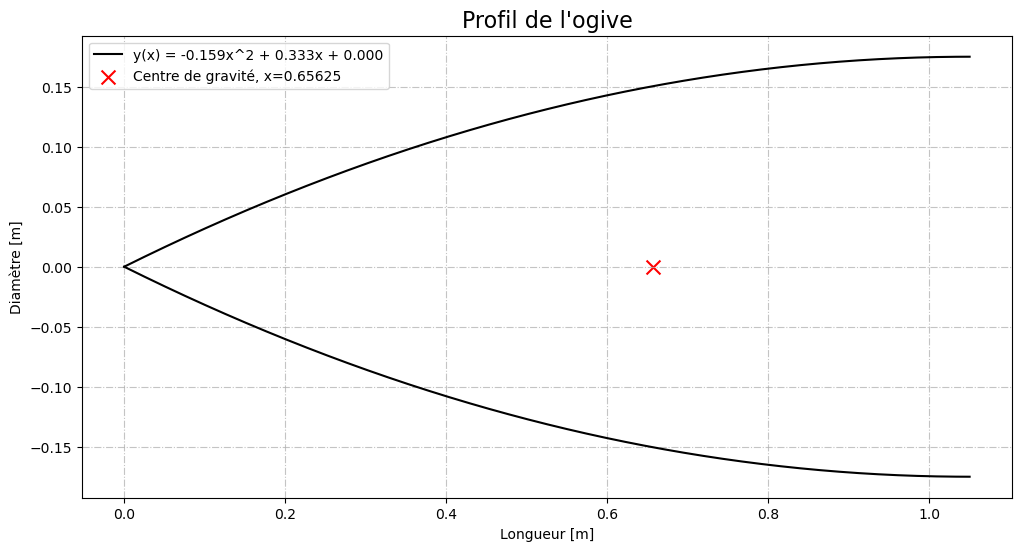

In [ ]:
from design_functions.generate_ogive_shape import generate_ogive_shape

x_ogive, y_ogive, x_CG_ogive = generate_ogive_shape(row=row, diametre=diametre, img_path=img_path)

<div class="alert alert-info" align="center"><b>CALCUL DU CENTRE DE GRAVITÉ</b></div>

In [ ]:
from design_functions.generate_missile_sections import generate_missile_section

section_missile = generate_missile_section(row=row, x_ogive=x_ogive, y_ogive=y_ogive, x_CG_ogive=x_CG_ogive)

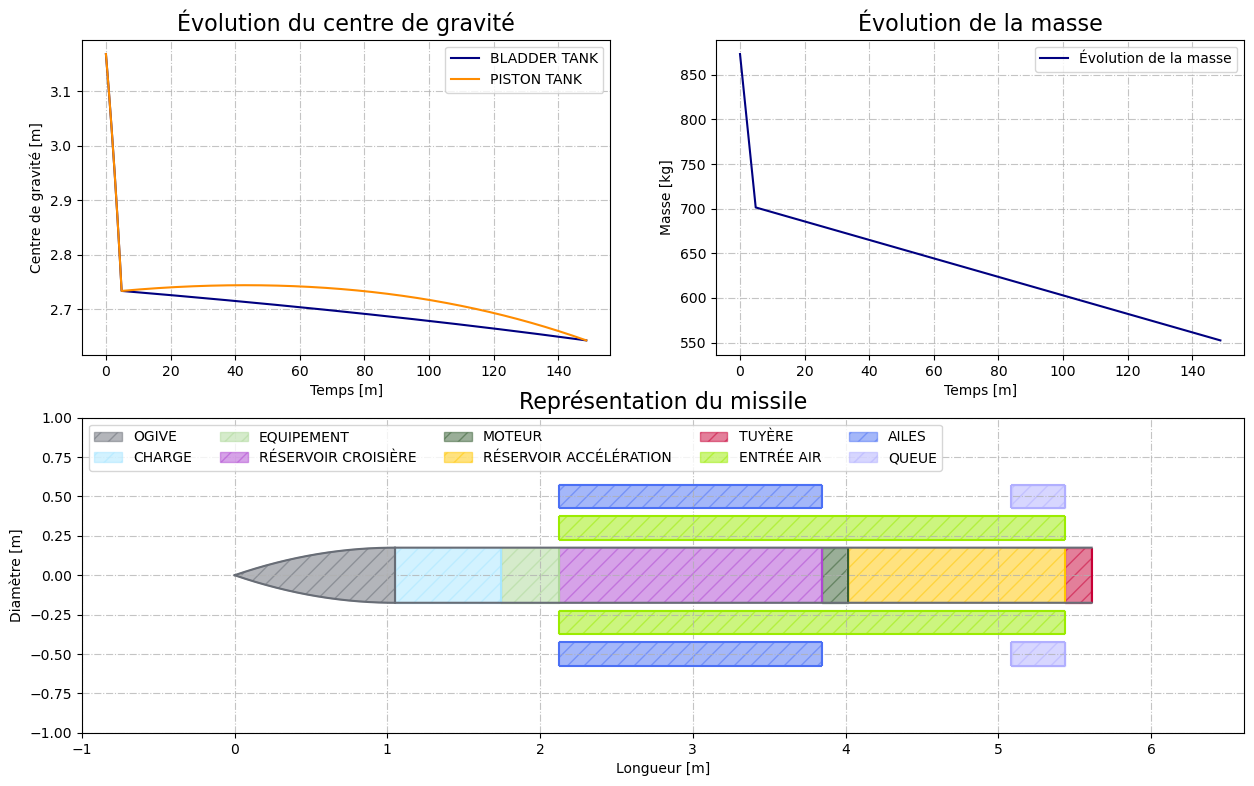

In [ ]:
from design_functions.generate_CG_missile import generate_CG_missile

mc_dot = row['m_cruise_prop'] / t_cruise
ma_dot = row["m_acc_prop"] / t_acc

m_dot = {
    'ma_dot': ma_dot,
    'mc_dot': mc_dot
}

CGx_dict, mass_dict, t_tot_array = generate_CG_missile(time=time, c=c, m_dot=m_dot, 
                                                       section_missile=section_missile, 
                                                       row=row, diametre=diametre, img_path=img_path)

In [ ]:
# fig, axes = plt.subplots(2, 2, figsize=(15, 9))

# axes.set_xlim([min(t), max(t)])
# axes.set_ylim([-2, 2])

# animated_plot, = axes.plot([], [])

# def update_data(frame):

#     animated_plot.set_data(t[:frame], y[:frame])
    
#     return animated_plot,

# animation = FuncAnimation(
#     fig=fig,
#     func=update_data,
#     frames=len(t),
#     interval=25,
#     repeat=False,
# )

# plt.show()